## Notebook to work with interaction dataset merge scenario `DR_CHN_Merging_ZS`
    - Roadway generation
    - Trajdata creation based on reading vehicle tracks from provided csv files

## Changelog
- Friday, Jan 31
    - Creation
    - Toy track generation using way if 10025 from `DR_CHN_Merging_ZS.osm`
- Monday, Feb 3
    - Begin trajdata creation to read in the vehicle tracks. Creation of struct called `INTERACTIONTrajdata`
- Tuesday, Feb 4
    - `Trajdata` reading nominally works. And rendered a scene of course without roadway. Some caveats
        - `car_df_index` line 21 onwards check is commented out
        - No `roadway` involved in the creation of `RecordState`
    - Made a video of replaying the trajdata, of course without roadway, just cars in the blackness
- Wednesday, Feb 5
    - roadway building using `generate_merging_roadway` from `AutonomousMerging.jl`
    - brought in `curevept_overlay` to do overlay the curve points that constitute a road
    - Drove a car in the merging scenario to check that lane semantics works i.e. vehicle understands
    how to keep lane
    - second roadway inspired by William Brannon curved merging lane
- Friday, Feb 7
    - Started pipeline to read Soyeon's centerline data files
    - Generated video replaying interaction dataset on roadways
- Monday, Feb 10
    - Cleanup to prepare for commit to `sisl/AutomotiveInteraction`
- Wednesday, Feb 12
    - Found that the vehicle state needs to have roadway information. Otherwise `observe!` in MOBIL cries
    - This means that we can't initialize the vehicle state the way we have done so far i.e. 
    without providing a `roadway` argument
    - Need to understand `lanes` and `lanetags` and modify roadway creation in terms of how tracks read from
    centerlines txt files into the roadway object

In [1]:
# usings
using AutomotiveDrivingModels # Driving simulation platform
using AutoViz # Visualization of roadways and vehicles
using DataFrames # For reading in vehicle tracks into specific type `Trajdata`
using Records # Storing the vehicle tracks in a format that can then be used by `AutomotiveDrivingModels`
using Reel # Make animations of scene visualizations created using `AutoViz`
using DelimitedFiles # Read in centerline txt files into arrays

In [2]:
# Bring functions into notebook: names are self explanatory
include("../src/roadway_building.jl")
include("../src/veh_track_reading.jl")
include("../src/visualization.jl");

## Read vehicle tracks from csv file
- Functions used (from `AutomotiveInteraction/src/veh_track_reading.jl`)
    - nframes
    - carsinframe
    - car_df_index

In [3]:
# script: read data from csv file into INTERACTIONTrajdata struct and prepare for next steps i.e.
# what Base.convert(::Type{Trajdata}, tdraw::NGSIMTrajdata, roadway::Roadway) does in NGSIM/trajdata.jl
tdraw = INTERACTIONTrajdata("../dataset/vehicle_tracks_000.csv");
df = tdraw.df
vehdefs = Dict{Int, VehicleDef}()
states = Array{RecordState{VehicleState, Int}}(undef, nrow(df))
frames = Array{RecordFrame}(undef, nframes(tdraw));

┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = ip:0x0
└ @ Core :-1


In [4]:
# script: initialize the vehicle definition in terms of type, length and width
for (id, dfind) in tdraw.car2start
    # CAUTION: Hardcoding vehicle type to be just car shown by the first argument being 2
    vehdefs[id] = VehicleDef(2, df[dfind, :length], df[dfind, :width])
    #if df[dfind,:agent_type] == "car"
    #    print("dfind is $(dfind)")
    #    print(df[dfind,:agent_type])
    #end
end

In [42]:
# tester function: proj_test
"""
Test the Vec.proj defined at this link
https://github.com/sisl/AutomotiveDrivingModels.jl/
blob/6bb5f82e7b56e75c158c796234e2e6a43efe46d7/src/roadways/roadways.jl#L609
"""
function proj_test(posG::VecSE2{T}, roadway::Roadway) where T <: Real

    best_dist2 = Inf
    best_proj = RoadProjection(CurveProjection(CurveIndex(-1,convert(T,-1.0)), 
                                               convert(T, NaN), 
                                               convert(T, NaN)),
                                NULL_LANETAG)

    for seg in roadway.segments
        #@show seg
        for lane in seg.lanes
            @show "lane loop starts"
            #@show lane
            roadproj = proj(posG, lane, roadway, move_along_curves=false)
            @show roadproj
            @show roadproj.tag
            targetlane = roadway[roadproj.tag]
            #@show targetlane
            footpoint = targetlane[roadproj.curveproj.ind, roadway]
            @show footpoint
            dist2 = normsquared(VecE2(posG - footpoint.pos))
            @show dist2
            if dist2 < best_dist2
                best_dist2 = dist2
                best_proj = roadproj
            end
        end
    end

    best_proj
end

proj_test

In [55]:
roadway_interaction[1].lanes

1-element Array{Lane{Float64},1}:
 Lane{Float64}(LaneTag(1, 1), CurvePt{Float64}[CurvePt({1146.270, 973.136, -2.940}, 0.000, 0.000, NaN), CurvePt({1146.236, 973.129, -2.940}, 0.035, 0.000, NaN), CurvePt({1146.141, 973.110, -2.940}, 0.131, 0.000, NaN), CurvePt({1145.994, 973.080, -2.940}, 0.282, 0.000, NaN), CurvePt({1145.800, 973.040, -2.940}, 0.479, 0.000, NaN), CurvePt({1145.567, 972.992, -2.940}, 0.717, 0.000, NaN), CurvePt({1145.303, 972.938, -2.940}, 0.987, 0.000, NaN), CurvePt({1145.013, 972.879, -2.940}, 1.282, 0.000, NaN), CurvePt({1144.706, 972.816, -2.940}, 1.596, 0.000, NaN), CurvePt({1144.388, 972.751, -2.940}, 1.920, 0.000, NaN)  …  CurvePt({1066.793, 960.069, -3.008}, 80.614, 0.000, NaN), CurvePt({1066.381, 960.013, -3.008}, 81.029, 0.000, NaN), CurvePt({1065.983, 959.960, -3.008}, 81.431, 0.000, NaN), CurvePt({1065.608, 959.909, -3.008}, 81.810, 0.000, NaN), CurvePt({1065.265, 959.863, -3.008}, 82.156, 0.000, NaN), CurvePt({1064.963, 959.823, -3.008}, 82.460, 0.000, NaN)

In [58]:
lanetags(roadway_interaction)

7-element Array{LaneTag,1}:
 LaneTag(1, 1)
 LaneTag(1, 2)
 LaneTag(1, 3)
 LaneTag(1, 4)
 LaneTag(1, 5)
 LaneTag(1, 6)
 LaneTag(1, 7)

In [49]:
roadway_interaction[LaneTag(1,2)]

BoundsError: BoundsError: attempt to access 1-element Array{Lane{Float64},1} at index [2]

In [43]:
# script: loop over data and create the vehicle state sequence. NOTE: THIS NEEDS THE ROADWAY
state_ind = 0

for frame in 1 : nframes(tdraw)

    frame_lo = state_ind+1

    for id in carsinframe(tdraw, frame)

        dfind = car_df_index(tdraw, id, frame)

        posG = VecSE2(df[dfind, :x], df[dfind, :y], df[dfind, :psi_rad])
        vx = df[dfind,:vx]
        vy = df[dfind,:vy]
        speed = sqrt(vx*vx + vy*vy)
@show posG
@show VehicleState(posG,speed)
@show proj_test(posG,roadway_interaction)
        @show Frenet(posG,roadway_interaction)
        @show VehicleState(posG,roadway_interaction,speed)
        states[state_ind += 1] = RecordState(VehicleState(posG, roadway_interaction, speed), id)
        #states[state_ind += 1] = RecordState(VehicleState(posG, speed), id)
    end

    frame_hi = state_ind
    frames[frame] = RecordFrame(frame_lo, frame_hi)
end
traj_interaction = Trajdata(INTERACTION_TIMESTEP, frames, states, vehdefs);

posG = VecSE2({1067.493, 959.049}, 3.106)
VehicleState(posG, speed) = VehicleState(VecSE2({1067.493, 959.049}, 3.106), Frenet(RoadIndex({-1, NaN}, {-1, -1}), NaN, NaN, NaN), 6.036)
"lane loop starts" = "lane loop starts"
roadproj = RoadProjection{Int64,Float64}(CurveProjection({369, 0.669}, 1.104, 6.114), LaneTag(1, 1))
roadproj.tag = LaneTag(1, 1)
footpoint = CurvePt({1067.346, 960.143, -3.008}, 80.056, -0.000, NaN)
dist2 = 1.2183385773064028
"lane loop starts" = "lane loop starts"
roadproj = RoadProjection{Int64,Float64}(CurveProjection({333, 0.470}, -0.026, 3.133), LaneTag(1, 2))
roadproj.tag = LaneTag(1, 2)


BoundsError: BoundsError: attempt to access 1-element Array{Lane{Float64},1} at index [2]

## centerlines_DR_Merging_CHN_ZS a.k.a read Soyeon roadways
- functions used (from `AutomotiveInteraction/src/roadway_building.jl)
    - centerlines_txt2tracks

In [6]:
# Read centerlines from Soyeon provided text files
track0 = centerlines_txt2tracks("../dataset/centerlines_DR_CHN_Merging_ZS/output_centerline_0.txt")
track1 = centerlines_txt2tracks("../dataset/centerlines_DR_CHN_Merging_ZS/output_centerline_1.txt")
track2 = centerlines_txt2tracks("../dataset/centerlines_DR_CHN_Merging_ZS/output_centerline_2.txt")
track3 = centerlines_txt2tracks("../dataset/centerlines_DR_CHN_Merging_ZS/output_centerline_3.txt")
track4 = centerlines_txt2tracks("../dataset/centerlines_DR_CHN_Merging_ZS/output_centerline_4.txt")
track5 = centerlines_txt2tracks("../dataset/centerlines_DR_CHN_Merging_ZS/output_centerline_5.txt")
track6 = centerlines_txt2tracks("../dataset/centerlines_DR_CHN_Merging_ZS/output_centerline_6.txt");

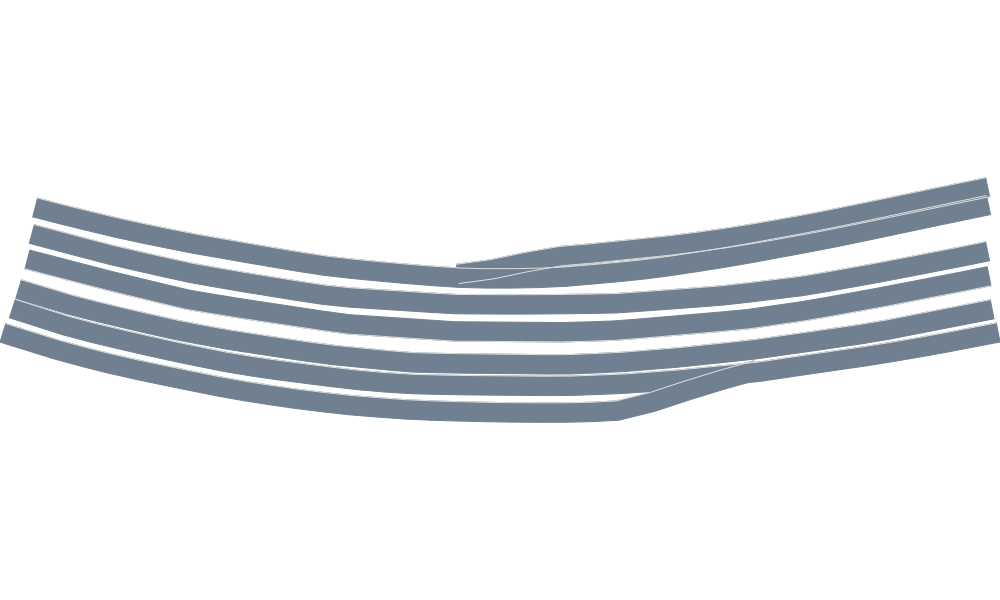

In [7]:
# Build a roadway using the tracks and render it
roadway_interaction = Roadway()
lane0 = Lane(LaneTag(1,1),track0)
lane1 = Lane(LaneTag(1,2),track1)
lane2 = Lane(LaneTag(1,3),track2)
lane3 = Lane(LaneTag(1,4),track3)
lane4 = Lane(LaneTag(1,5),track4)
lane5 = Lane(LaneTag(1,6),track5)
lane6 = Lane(LaneTag(1,7),track6)
push!(roadway_interaction.segments, RoadSegment(1, [lane0]))
push!(roadway_interaction.segments, RoadSegment(1, [lane1]))
push!(roadway_interaction.segments, RoadSegment(1, [lane2]))
push!(roadway_interaction.segments, RoadSegment(1, [lane3]))
push!(roadway_interaction.segments, RoadSegment(1, [lane4]))
push!(roadway_interaction.segments, RoadSegment(1, [lane5]))
push!(roadway_interaction.segments, RoadSegment(1, [lane6]))

render(roadway_interaction, cam=FitToContentCamera(0.))

In [8]:
# Get a scene from the vehicle track information read in earlier and render on the road
scene = Scene(500)
get!(scene,traj_interaction,1);
# render(scene,roadway_interaction)

In [ ]:
# Make a video that gets saved to the folder AutomotiveInteraction/julia_notebooks/media
video_trajdata_replay(range=1:100,filename="media/vid_$(range).mp4")

## Driving simulation functions

In [9]:
# models creation: 2d driver model for the merging roadway
models = Dict{Int64,DriverModel}()
for veh in scene
    models[veh.id] = Tim2DDriver(0.1,mlane=MOBIL(INTERACTION_TIMESTEP,mlon=IntelligentDriverModel()))
end

In [10]:
# function: get hallucination scenes
"""
    function get_hallucination_scenes
- Hallucinate starting from `start_step` for `nsteps` using `models` and return a list of scenes
- Used by `plot_carwise_pos_vel` to assess position and velocity traces against ground truth

# Returns
- `halluc_scenes_list`: List containing the scenes starting with the ground truth scene at `start_step`

# Examples
```julia
scene_list = get_hallucination_scenes(start_scene,nsteps=100,models=models);
```
"""
function get_hallucination_scenes(scene_halluc;models,start_step=1,duration=3,id_list=[],
        traj=traj_interaction,verbosity = false,timestep=INTERACTION_TIMESTEP,roadway=roadway_interaction)
        # Setting up
    halluc_scenes_list = []
    #scene_halluc = get_scene(start_step,traj) # Frame to start hallucination from
    push!(halluc_scenes_list,deepcopy(scene_halluc))
    
    nsteps = duration/timestep
    for (i,t) in enumerate(start_step:start_step+nsteps-1)
        
        if !isempty(id_list) keep_vehicle_subset!(scene_halluc,id_list) end
        
        actions = Array{Any}(undef,length(scene_halluc))

            # Propagation of scene forward
        get_actions!(actions,scene_halluc,roadway,models)

        tick!(scene_halluc,roadway,actions,timestep)
        
        push!(halluc_scenes_list,deepcopy(scene_halluc))
    end 
    return halluc_scenes_list
end

get_hallucination_scenes

In [13]:
scene[1].state.posF.roadind.tag.segment

-1

In [11]:
scene_list = get_hallucination_scenes(scene,models=models);

ErrorException: Could not find segid -1 in roadway